# Compare Results With and Without Inter-room Air Movement

Here we run two simulations in our simple office. In the first, we only include air exchange between the rooms and the HVAC system, and in the second, we also include air exchange between adjacent rooms.

We infect some people and run a single day in a repeatable way to compare the concentrations in the various rooms.

In [1]:
import os
import random
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from apsrm import Box
from apsrm.config import DEFAULT_STRAIN
from apsrm.ext.plot import shedding_plot, plot_concentrations
from apsrm.ext.simulation import create_pathogen
from utils import (
    BOX_TYPE,
    create_workplace,
    create_emissions_calculator)

OUTPUT_BASE_DIR = '../../outputs/office'
def opath(p):
    bd = OUTPUT_BASE_DIR if os.path.exists(OUTPUT_BASE_DIR) else '.'
    return os.path.join(bd, 'vent_comp_{}'.format(p))

seed = 1
hvac_recirculation_rate = 7.
n_workers = 40
external_acph = 1.

hvac = Box(1., BOX_TYPE.HVAC, 0, name='hvac')

workplace = create_workplace(n_workers=n_workers, n_receptionists=1)
workplace.add_box(hvac)

boxes = workplace.boxes
n_boxes = len(boxes)

# Note that this just contains volume because we multiply this by apprpriate things below.
ventilation_matrix = np.zeros((n_boxes, n_boxes))
ventilation_matrix[:,hvac.box_index] = ventilation_matrix[hvac.box_index,:] = np.array([b.volume for b in boxes])
ventilation_matrix[hvac.box_index, hvac.box_index] = 0.

external_ventilation = np.zeros(n_boxes)
external_ventilation[hvac.box_index] = external_acph * (sum([b.volume for b in boxes]) - hvac.volume)

pathogen = create_pathogen(DEFAULT_STRAIN)
emissions_calculator = create_emissions_calculator(pathogen)

day_of_simulation = 0
def reset():
    np.random.seed(seed=seed)
    random.seed(seed)
    workplace.reset(True)
    for i in range(day_of_simulation-4, day_of_simulation):
        workplace.infect_random_persons(pathogen, i)

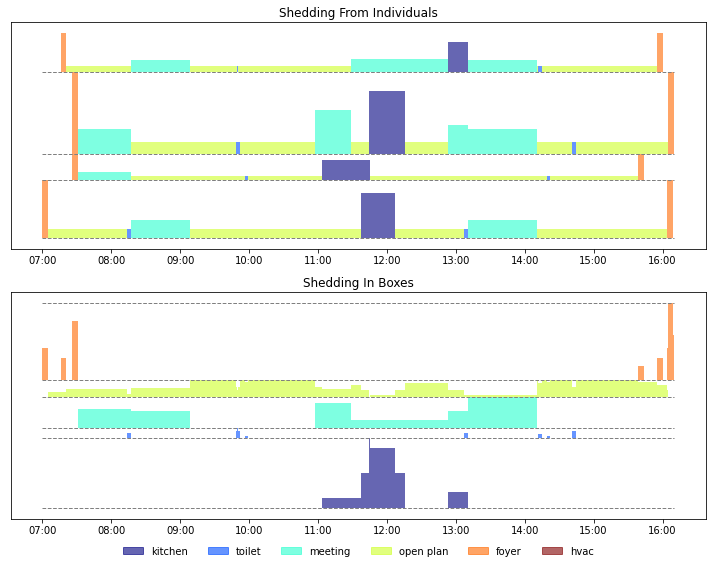

In [2]:
reset()
workplace.run_period(4, pathogen, emissions_calculator)
shedding_plot(
    workplace,
    opath('shedding.pdf'),
    show_boxes=True,
    show_concentrations=False)

## No Air Exchange

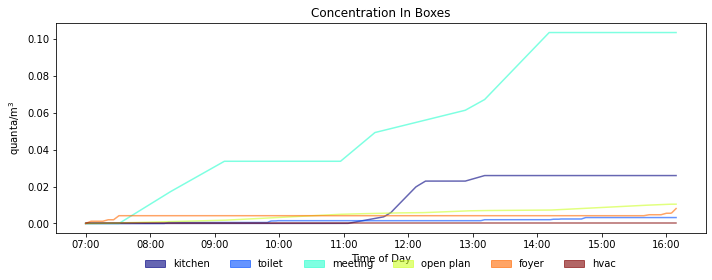

In [3]:
no_hvac_boxes = deepcopy(workplace.boxes)
no_hvac_vs = deepcopy(workplace.ventilation_system)
shedding_plot(
    workplace,
    show_boxes=False,
    show_concentrations=True)

## HVAC setup as no HVA

Results should be almost identical to above.

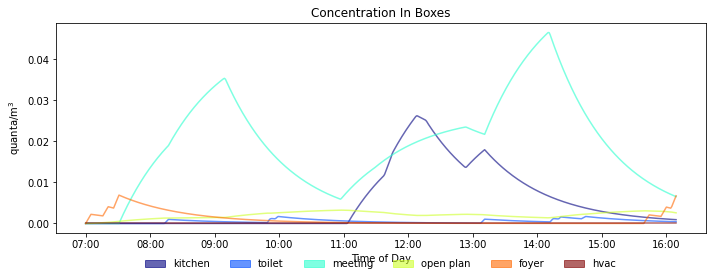

In [4]:
# Doesn't matter if we include the HVAC box here (never has shedding in it).
workplace.set_ventilation_properties(
    external_ventilation = np.array([external_acph * b.volume for b in workplace.boxes]),
    force_standard_hvac_system = True)
reset()
workplace.run_period(day_of_simulation, pathogen, emissions_calculator)
shedding_plot(
    workplace,
    show_boxes=False,
    show_concentrations=True)
zero_hvac_boxes = deepcopy(workplace.boxes)
zero_hvac_vs = deepcopy(workplace.ventilation_system)

## Exchange With HVAC Only

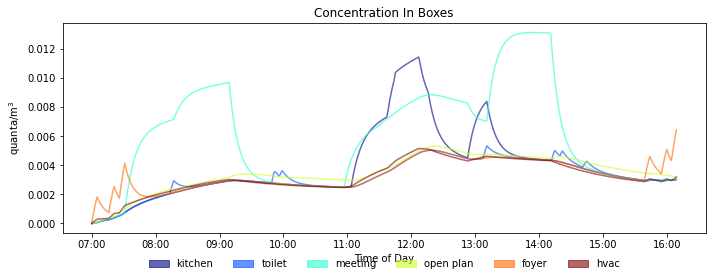

In [5]:
workplace.set_ventilation_properties(
    ventilation_matrix = hvac_recirculation_rate * ventilation_matrix,
    hvac_box_type = hvac.use,
    external_ventilation = external_ventilation)
reset()
workplace.run_period(day_of_simulation, pathogen, emissions_calculator)
shedding_plot(
    workplace,
    show_boxes=False,
    show_concentrations=True)
hvac_only_boxes = deepcopy(workplace.boxes)
hvac_only_vs = deepcopy(workplace.ventilation_system)

## Exchange With HVAC and Rooms

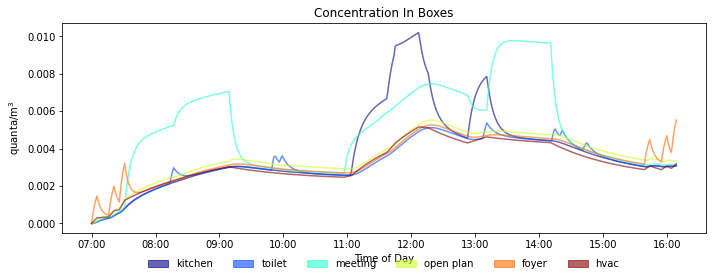

In [6]:
rooms = np.array([
    [   0.  ,    0.  ,    0.  ,  270.  ,    0.  , 0.],
    [   0.  ,    0.  ,    0.  ,   75.  ,    0.  , 0.],
    [   0.  ,    0.  ,    0.  ,  371.25,    0.  , 0.],
    [ 270.  ,   75.  ,  371.25,    0.  , 1305.  , 0.],
    [   0.  ,    0.  ,    0.  , 1305.  ,    0.  , 0.],
    [   0.  ,    0.  ,    0.  ,    0.  ,    0.  , 0.]])
workplace.set_ventilation_properties(
    ventilation_matrix = hvac_recirculation_rate * ventilation_matrix + rooms,
    hvac_box_type = hvac.use,
    external_ventilation = external_ventilation)
reset()
workplace.run_period(day_of_simulation, pathogen, emissions_calculator)
shedding_plot(
    workplace,
    show_boxes=False,
    show_concentrations=True)
hvac_and_rooms_boxes = deepcopy(workplace.boxes)
hvac_and_rooms_vs = deepcopy(workplace.ventilation_system)

## Exchange with HVAC Only at Half Rate

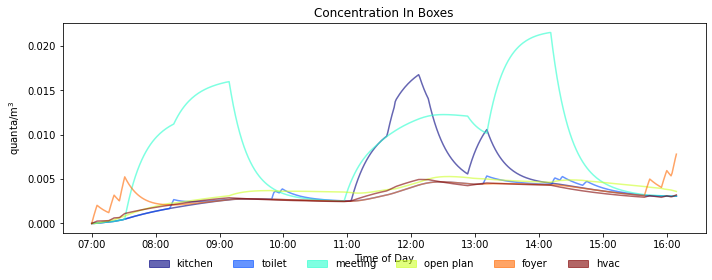

In [7]:
workplace.set_ventilation_properties(
    ventilation_matrix = .5 * hvac_recirculation_rate * ventilation_matrix,
    hvac_box_type = hvac.use,
    external_ventilation = external_ventilation)
reset()
workplace.run_period(day_of_simulation, pathogen, emissions_calculator)
shedding_plot(
    workplace,
    show_boxes=False,
    show_concentrations=True)
half_hvac_boxes = deepcopy(workplace.boxes)
half_hvac_vs = deepcopy(workplace.ventilation_system)

## Portable Air Filters

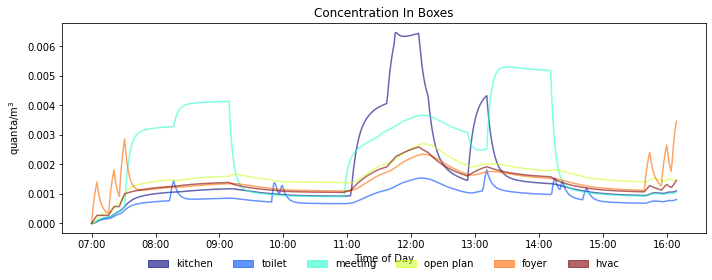

In [8]:
workplace.set_ventilation_properties(
    ventilation_matrix = hvac_recirculation_rate * ventilation_matrix + rooms,
    hvac_box_type = hvac.use,
    external_ventilation = external_ventilation,
    internal_filtering_efficiency = .8,
    internal_filtering_volume = 350.)
reset()
workplace.run_period(day_of_simulation, pathogen, emissions_calculator)
shedding_plot(
    workplace,
    show_boxes=False,
    show_concentrations=True)
hvac_portable_boxes = deepcopy(workplace.boxes)
hvac_portable_vs = deepcopy(workplace.ventilation_system)

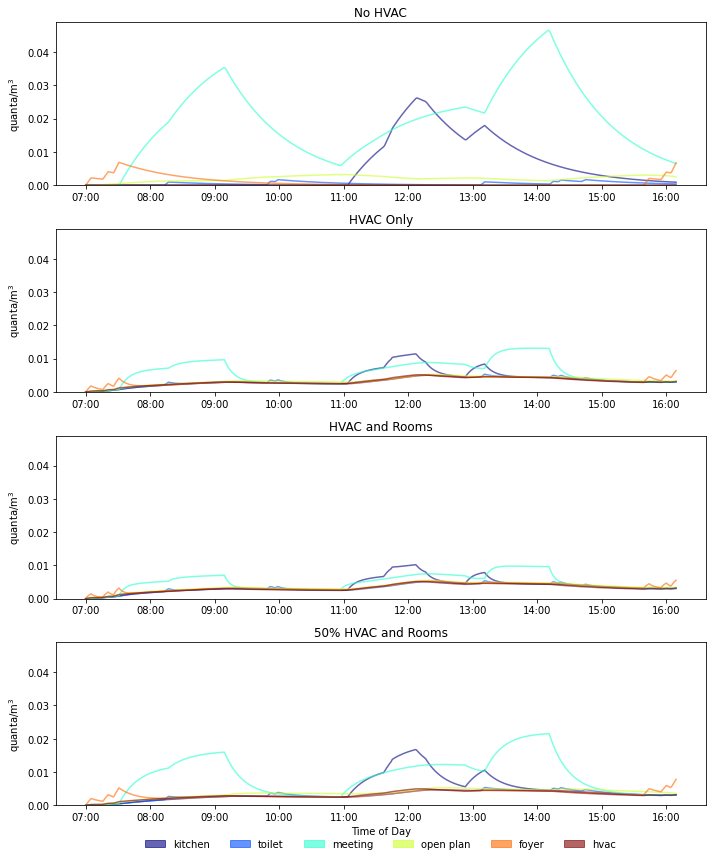

In [10]:
boxess = (zero_hvac_boxes, hvac_only_boxes, hvac_and_rooms_boxes, half_hvac_boxes)#, hvac_portable_boxes)
vss = (zero_hvac_vs, hvac_only_vs, hvac_and_rooms_vs, half_hvac_vs)#, hvac_portable_vs)
titles = ('No HVAC', 'HVAC Only', 'HVAC and Rooms', '50% HVAC and Rooms')#, 'e. Portable AF')

day_start = workplace.day_start
day_end = workplace.day_end

times = np.arange(day_start, day_end, 1./60.)
max_conc = 1.05 * np.max(zero_hvac_vs.current_soln.y)

fig, axs = plt.subplots(len(boxess), figsize=(10, 3. * len(boxess)))
#fig.tight_layout()
fig.subplots_adjust(hspace=0.26)

for i, (boxes, vs, title, ax) in enumerate(zip(boxess, vss, titles, axs)):
    plot_concentrations(
        ax,
        vs,
        boxes,
        day_start,
        day_end,
        title = title,
        x_axs_title = 'Time of Day' if i == len(boxess) - 1 else None,
        ylim = [0, max_conc],
        include_legend = i == len(boxess) - 1)
plt.tight_layout()
plt.savefig(opath('conc_combined.pdf'))#, bbox_inches='tight')